# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


the goal of this notebook is to see whether BMCA can use data where two enzymes have been perturbed in one experiment. 

In [2]:
os.chdir('../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/')

In [3]:
os.getcwd()

'c:\\Users\\user\\Documents\\research\\BMCA-pipeline\\notebooks\\topologyA'

In [4]:
Teusink_ant ='../../models/Antimony/Simplified_Teusink_yeast.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [5]:
data_file01 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_0.1.csv'
data_file02 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_0.2.csv'
data_file03 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_0.3.csv'
data_file04 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_0.4.csv'

data_file05 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_0.5.csv'
data_file10 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_1.01.csv'
data_file15 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_1.5.csv'
data_file3 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_3.csv'
data_file5 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_5.csv'
data_file7 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_7.csv'
data_file100 = '../../data/interim/generated_data/simplTeusink-noReg/combined_pt/Simplified_Teusink_yeast_10.csv'


In [7]:
BMCA_obj01 = antemll.antemll(Teusink_ant, data_file01)
BMCA_obj02 = antemll.antemll(Teusink_ant, data_file02)
BMCA_obj03 = antemll.antemll(Teusink_ant, data_file03)
BMCA_obj04 = antemll.antemll(Teusink_ant, data_file04)
BMCA_obj05 = antemll.antemll(Teusink_ant, data_file05)
BMCA_obj10 = antemll.antemll(Teusink_ant, data_file10)
BMCA_obj15 = antemll.antemll(Teusink_ant, data_file15)
BMCA_obj3 = antemll.antemll(Teusink_ant, data_file3)
BMCA_obj5 = antemll.antemll(Teusink_ant, data_file5)
BMCA_obj7 = antemll.antemll(Teusink_ant, data_file7)
BMCA_obj100 = antemll.antemll(Teusink_ant, data_file100)


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../models/Antimony/Simplified_Teusink_yeast_cobra.ant


In [8]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,890.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,959.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,561.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,122.7
c:\Users\user\miniconda3\envs\gayles\lib\site-packages\pymc\model.py:1406: ImputationWarning:

Data in e_obs contains missing values and will be automatically imputed from the sampling distribution.

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\pymc\model.py:1406: ImputationWarning:

Data in chi_obs contains missing values and will be automatically imputed from the sampling distribution.

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\pymc\model.py:1406: ImputationWarning:

Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.

c:\Users\user\miniconda3\envs\gayles\lib\site-packages\pymc\model.py:1406: ImputationWarning:

Data in v_hat_obs contains missing values and will be automatically imputed from the sampling distribution.



c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,139


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 916.86


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 977.15


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,223.4


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,116


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 7,162.5


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 14,663


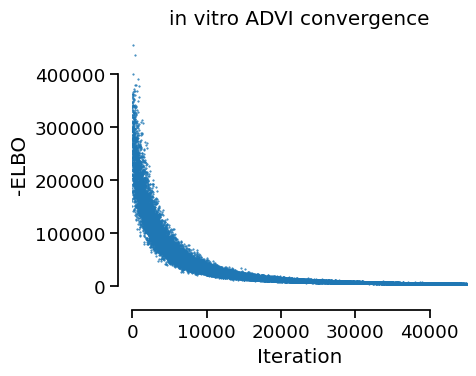

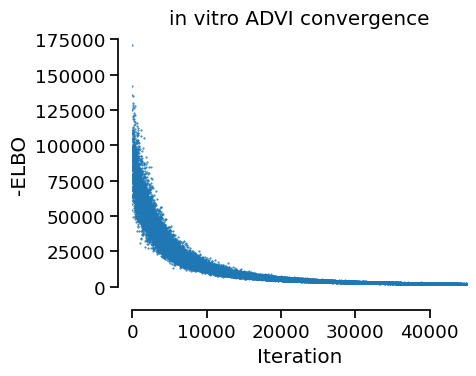

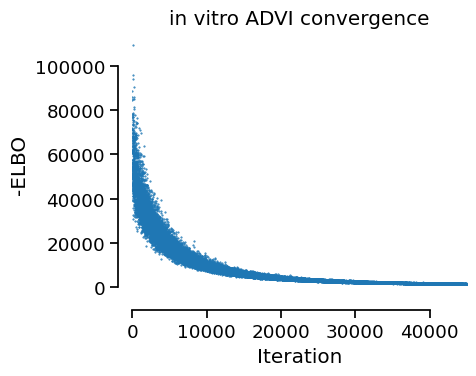

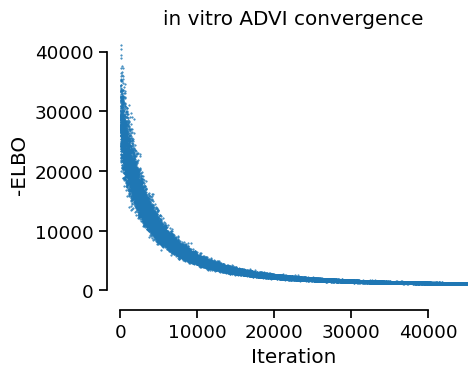

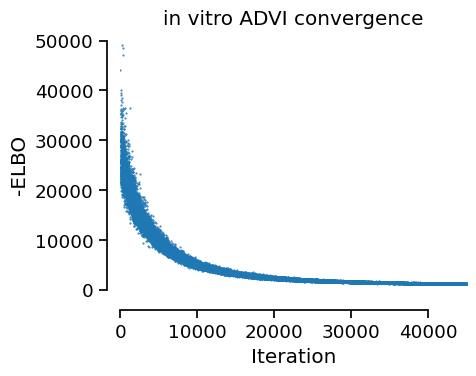

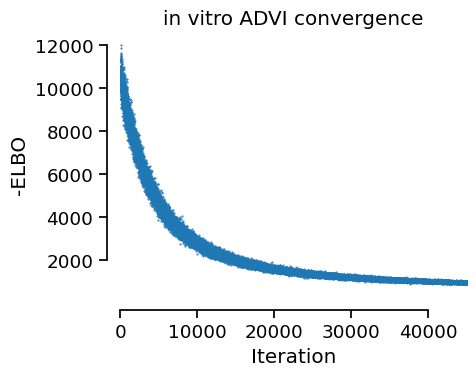

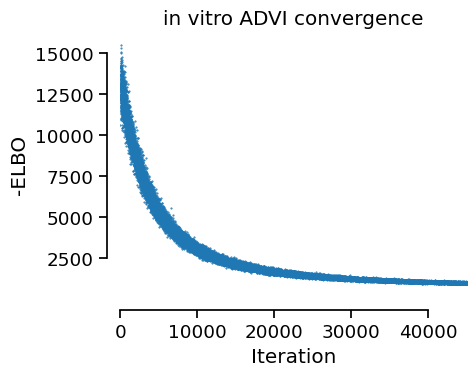

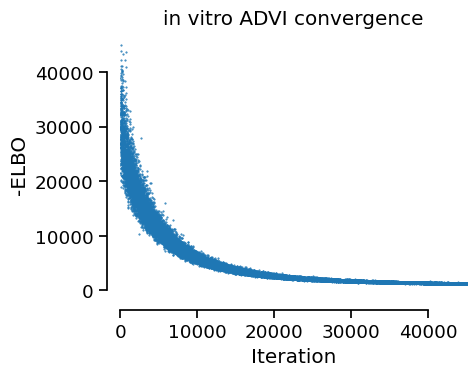

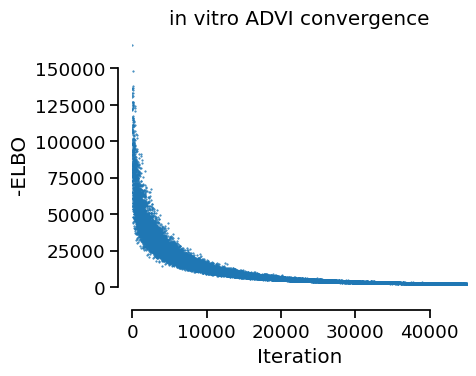

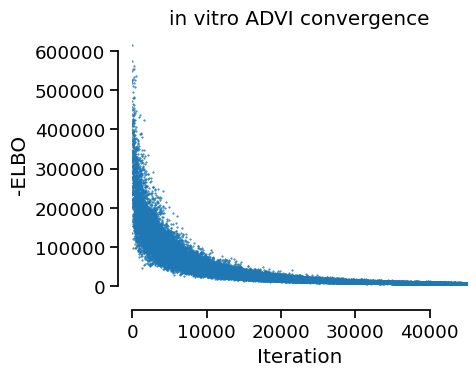

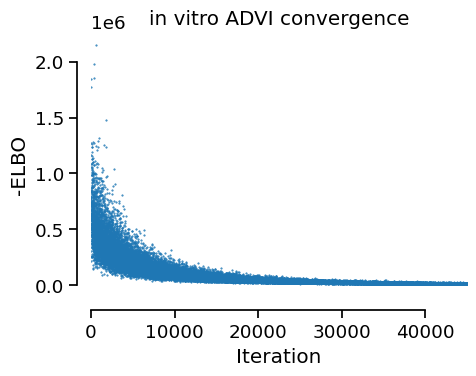

In [9]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)
trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

## Plotting ADVI results

In [10]:
def get_az_summary(t): 
    Ex_mean = az.summary(t)['mean'].reset_index()
    Ex_mean.columns = ['elasticity', 'mean']
    Ex_mean = Ex_mean[Ex_mean.elasticity.str.contains("Ex\[")]['mean'].values.flatten().reshape((-1,1))
    return np.mean(Ex_mean, axis=1)

In [11]:
Ex01_advi = get_az_summary(trace01)
Ex02_advi = get_az_summary(trace02)
Ex03_advi = get_az_summary(trace03)
Ex04_advi = get_az_summary(trace04)

Ex05_advi = get_az_summary(trace05)
Ex10_advi = get_az_summary(trace10)
Ex15_advi = get_az_summary(trace15)
Ex3_advi = get_az_summary(trace3)
Ex5_advi = get_az_summary(trace5)
Ex7_advi = get_az_summary(trace7)
Ex100_advi = get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [12]:
r.getScaledElasticityMatrix()

               G6P,      TRIO,      ACE,      P3G,       PEP,      GLCi,       F6P,       BPG,       PYR,     F16P,       P2G
vGLK   [[ -1.43765,         0,        0,        0,         0,   1.44964,         0,         0,         0,        0,         0],
vPGI    [  1.40347,         0,        0,        0,         0,         0, -0.953057,         0,         0,        0,         0],
vGLYCO  [        1,         0,        0,        0,         0,         0,         0,         0,         0,        0,         0],
vTreha  [        1,         0,        0,        0,         0,         0,         0,         0,         0,        0,         0],
vPFK    [        0,         0,        0,        0,         0,         0,   1.38303,         0,         0, -1.03688,         0],
vALD    [        0, -0.823896,        0,        0,         0,         0,         0,         0,         0,  1.10649,         0],
vGAPDH  [        0,  0.969712,        0,        0,         0,         0,         0, -0.705532,         0, 

## Calculating FCCs

In [13]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [14]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)
    print(a.shape)
    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [15]:
Ex01_advi.shape

(176,)

In [16]:
postFCC01 = estimate_CCs(BMCA_obj01, Ex01_advi.reshape((16,11)))
postFCC02 = estimate_CCs(BMCA_obj02, Ex02_advi.reshape((16,11)))
postFCC03 = estimate_CCs(BMCA_obj03, Ex03_advi.reshape((16,11)))
postFCC04 = estimate_CCs(BMCA_obj04, Ex04_advi.reshape((16,11)))

postFCC05 = estimate_CCs(BMCA_obj05, Ex05_advi.reshape((16,11)))
postFCC10 = estimate_CCs(BMCA_obj10, Ex10_advi.reshape((16,11)))
postFCC15 = estimate_CCs(BMCA_obj15, Ex15_advi.reshape((16,11)))
postFCC3 = estimate_CCs(BMCA_obj3, Ex3_advi.reshape((16,11)))
postFCC5 = estimate_CCs(BMCA_obj5, Ex5_advi.reshape((16,11)))
postFCC7 = estimate_CCs(BMCA_obj7, Ex7_advi.reshape((16,11)))
postFCC100 = estimate_CCs(BMCA_obj100, Ex100_advi.reshape((16,11)))

(1000, 16, 16)
(1000, 16, 16)
(1000, 16, 16)
(1000, 16, 16)


ERROR (aesara.graph.rewriting.basic): Rewrite failure due to: constant_folding


(1000, 16, 16)


ERROR (aesara.graph.rewriting.basic): node: for{cpu,scan_fn}(TensorConstant{1000}, TensorConstant{[[[nan nan..nan nan]]]}, TensorConstant{[[[ 2.2618..       ]]]}, TensorConstant{1000})
ERROR (aesara.graph.rewriting.basic): TRACEBACK:
ERROR (aesara.graph.rewriting.basic): Traceback (most recent call last):
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\link\vm.py", line 414, in __call__
    thunk()
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\graph\op.py", line 543, in rval
    r = p(n, [x[0] for x in i], o)
  File "c:\Users\user\Documents\research\BMCA-pipeline\emll\aesara_utils.py", line 89, in perform
    output_storage[0][0] = lstsq_wrapper(A, b, driver=self.driver)
  File "c:\Users\user\Documents\research\BMCA-pipeline\emll\aesara_utils.py", line 145, in lstsq_wrapper
    x, _, _, _ = sp.linalg.lstsq(A, b, check_finite=True, lapack_driver=driver)
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\scipy\linalg\_basic.py", l

ValueError: array must not contain infs or NaNs
Apply node that caused the error: LeastSquaresSolve{driver='gelsy', assume_a='gen', lower=False, check_finite=True}(*0-<TensorType(float64, (None, None))>, *1-<TensorType(float64, (None, None))>)
Toposort index: 0
Inputs types: [TensorType(float64, (None, None)), TensorType(float64, (None, None))]
Inputs shapes: [(11, 11), (11, 16)]
Inputs strides: [(88, 8), (128, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [['output']]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15788\2245787670.py", line 6, in <module>
    postFCC05 = estimate_CCs(BMCA_obj05, Ex05_advi.reshape((16,11)))
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15788\2750478701.py", line 20, in estimate_CCs
    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scan\basic.py", line 865, in scan
    raw_inner_outputs = fn(*args)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15788\2750478701.py", line 20, in <lambda>
    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15788\2750478701.py", line 18, in solve_aesara
    return rsolve_op(A, b).squeeze()

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.
Apply node that caused the error: for{cpu,scan_fn}(TensorConstant{1000}, TensorConstant{[[[nan nan..nan nan]]]}, TensorConstant{[[[ 2.2618..       ]]]}, TensorConstant{1000})
Toposort index: 0
Inputs types: [TensorType(int64, ()), TensorType(float64, (1000, 11, 11)), TensorType(float64, (1000, 11, 16)), TensorType(int64, ())]
Inputs shapes: [(), (1000, 11, 11), (1000, 11, 16), ()]
Inputs strides: [(), (968, 88, 8), (1408, 128, 8), ()]
Inputs values: [array(1000, dtype=int64), 'not shown', 'not shown', array(1000, dtype=int64)]
Outputs clients: [['output']]

Backtrace when the node is created (use Aesara flag traceback__limit=N to make it longer):
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
    result = self._run_cell(
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
    result = runner(coro)
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "c:\Users\user\miniconda3\envs\gayles\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15788\2245787670.py", line 6, in <module>
    postFCC05 = estimate_CCs(BMCA_obj05, Ex05_advi.reshape((16,11)))
  File "C:\Users\user\AppData\Local\Temp\ipykernel_15788\2750478701.py", line 20, in estimate_CCs
    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),

HINT: Use the Aesara flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
rxn_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [ ]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [ ]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

### Graphing the averaged differences between ground truth and predicted distributions

In [ ]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')
"""
    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')
"""

In [ ]:
plt.close("all")

## Evaluating FCC ranking

In [ ]:
## ground truth FCC rankings for vADH

gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vADH']

### via Spearman rank coefficients

In [ ]:
def calculate_FCC_med_rankings(postFCC, reaction='vADH'):
    postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    m1 = postFCC_med.index.values[:, None] == postFCC_med.columns.values
    postFCC = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=postFCC_med.columns, index=postFCC_med.index)
    postFCC_rankings= postFCC.rank(axis=1, ascending=False, na_option='keep')
    
    return postFCC_rankings.loc[reaction]
    

In [ ]:
spearman_coefficients = []
b_list = []
for FCC in rxn_FCCs:
    b = calculate_FCC_med_rankings(FCC)
    b_list.append(b)
    spearman_coefficients.append(stats.spearmanr(a.dropna().values, b.dropna().values))

In [ ]:
spearman_coefficients

In [ ]:
plt.bar(pt_labels, [i[0] for i in spearman_coefficients], alpha=0.5, color='r')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

In [ ]:
plt.plot(pt_labels, [i[0] for i in spearman_coefficients],'ro')
plt.grid()

for i, txt in enumerate([i[1].round(3) for i in spearman_coefficients]):
    plt.annotate(txt, (pt_labels[i], [i[0] for i in spearman_coefficients][i]), ha='center')

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

### evaluating top five rankings

In [ ]:
ranked_b_list = [b.sort_values().reset_index().set_index('vADH') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vADH')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q

In [ ]:
q.to_csv('simplTeusink_rankings.csv')